In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 16
pred_csv = f"./output/donors_state{year}_pred_lastname.csv"
donors_csv = f"./data/CampaignFin{year}/donors_recip{year}.csv"
cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,recip_id,name,name_new,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation
0,U00000036521,C00547349,"STEYER, THOMAS F",thomas f steyer,JE300,M,FOUNDER,"FAHR, LLC",SAN FRANCISCO,CA,89500000.0,14,6.392857e+06,6500000.0
1,,C00572958,PHILADELPHIA CONVENTION & VISITORS BUREAU FOUN...,philadelphia convention & visitors bureau foun...,Y4000,,NaN,NaN,PHILADELPHIA,PA,73299329.0,425,1.724690e+05,25000.0
2,,C00567057,AT&T,keycorp keycorp,Z9600,,NaN,NaN,CLEVELAND,OH,65268589.0,390,1.673554e+05,50000.0
3,,C00616078,STATWARE INC AND OTHER FIRMS,statware inc and other firms statware inc and ...,Z9600,,NaN,NaN,NEW YORK,CT,50325977.0,4,1.258149e+07,162738.5
4,,C00620971,AFSCME SPECIAL ACCOUNT,afscme special account afscme special account,Z9600,,NaN,NaN,WASHINGTON,DC,43280642.0,53,8.166159e+05,102021.0
5,,C00010603,NaN,,G6550,,NaN,NaN,PARK RIDGE,NY,42469722.0,106,4.006578e+05,20000.0
6,,C00495861,PRECISION NETWORK LLC,precision network llc precision network llc,Z9600,,NaN,NaN,WASHINGTON,DC,30985619.0,82,3.778734e+05,150000.0
7,,C00571372,CENTURY HOMEBUILDERS GROUP LLC,century homebuilders group llc century homebui...,Y4000,,NaN,NaN,TALLAHASSEE,FL,30552479.0,633,4.826616e+04,5000.0
8,,C00571703,ZUFFA LLC,zuffa llc zuffa llc,Z9600,,NaN,NaN,LAS VEGAS,NV,30111804.0,93,3.237828e+05,50000.0
9,,C00490730,REPUBLICAN GOVERNORS ASSOCIATION,republican governors association republican go...,Z5100,,NaN,NaN,WASHINGTON,DC,22732845.0,25,9.093138e+05,1000000.0


In [4]:
cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'seat_current', 'ran_general', 'ran_ever', 'type', 
                        'recipcode', 'nopacs'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'seat_current', 
                 'ran_general', 'ran_ever', 'type', 'recipcode'])
    )

cands = cands_lf.collect()
cands = cands.to_pandas()
cands = cands.drop_duplicates(subset=['recip_id', 'name', 'party', 'seat'], keep='last')
cands[(cands["seat"] == "PRES") & (cands["ran_general"] == "Y")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
4610,P20003984,N00033776,Jill Stein (3),3,PRES,,Y,Y,O,3L
6499,P60022654,N00040318,Evan McMullin (I),I,PRES,,Y,Y,O,3L
6607,P80001571,N00023864,Donald Trump (R),R,PRES,,Y,Y,O,RW


In [5]:
cands[cands["recip_id"].str.contains("N")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
1,H00000002,N00038583,PETER SHERRILL (R),R,PRES,,,,,RN
2,H0AK00097,N00032846,John Cox (R),R,AK01,,,,,RN
3,H0AL02087,N00030768,Martha Roby (R),R,AL02,AL02,Y,Y,I,RW
4,H0AL02095,N00030850,Rob John (I),I,AL02,,Y,Y,C,3L
5,H0AL05049,N00003042,Bud Cramer (D),D,AL05,,,,,DN
...,...,...,...,...,...,...,...,...,...,...
7711,S8WA00137,N00007929,Thor Amundson (D),D,WAS2,,,Y,C,DL
7712,S8WA00186,N00009960,Deborah Senn (D),D,WAS2,,,,,DN
7713,S8WA00194,N00007836,Maria Cantwell (D),D,WAS1,WAS1,,,I,DI
7714,S8WI00026,N00000036,Russ Feingold (D),D,WIS2,,Y,Y,C,DL


In [6]:
mapping = {
    'A': 'Agribusiness',
    'B': 'Construction',
    'C': 'Tech',
    'D': 'Defense',
    'E': 'Energy',
    'F': 'Finance',
    'M': 'Misc Business',
    'H': 'Health',
    'J': 'Ideology/Single Issue',
    'K': 'Law',
    'L': 'Labor',
    'M': 'Manufacturing',
    'T': 'Transportation',
    'W': 'Other',
    'Y': 'Unknown',
    'Z': 'Party'
}

donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
donors["sector"].value_counts()

sector
Unknown                  732936
Health                   383444
Finance                  365945
Ideology/Single Issue    280250
Law                      191744
Tech                     159916
Party                    107263
Labor                     96630
Energy                    84134
Construction              82836
Transportation            81422
Agribusiness              63335
Manufacturing             48741
Defense                   32944
Name: count, dtype: int64

In [7]:
preds = pd.read_csv(pred_csv)
donors = donors.merge(preds[['contrib_id', 'ethnic']], on='contrib_id', how='left')
donors = donors.merge(cands, on='recip_id', how='left')

In [8]:
contrib_party_totals = (
    donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']
    .sum()
    .unstack()
    .fillna(0)
)

contrib_party_totals['dem_ratio'] = (
    contrib_party_totals.get('D', 0) / 
    (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))
)

donors = donors.merge(
    contrib_party_totals['dem_ratio'].reset_index(),
    on=['contrib_id', 'name_new'],
    how='left'
)

donors

,contrib_id,recip_id,name_x,name_new,realcode,gender,occupation,employer,city,state,...,id,name_y,party,seat,seat_current,ran_general,ran_ever,type,recipcode,dem_ratio
0,U00000036521,C00547349,"STEYER, THOMAS F",thomas f steyer,JE300,M,FOUNDER,"FAHR, LLC",SAN FRANCISCO,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,,C00572958,PHILADELPHIA CONVENTION & VISITORS BUREAU FOUN...,philadelphia convention & visitors bureau foun...,Y4000,,NaN,NaN,PHILADELPHIA,PA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,,C00567057,AT&T,keycorp keycorp,Z9600,,NaN,NaN,CLEVELAND,OH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,C00616078,STATWARE INC AND OTHER FIRMS,statware inc and other firms statware inc and ...,Z9600,,NaN,NaN,NEW YORK,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,C00620971,AFSCME SPECIAL ACCOUNT,afscme special account afscme special account,Z9600,,NaN,NaN,WASHINGTON,DC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884777,p0005231805,C00019331,"SAVALL, MARY L",mary l savall,Y2000,F,INFORMATION REQUESTED,INFORMATION REQUESTED,MADISON,WI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3884778,p0004434714,N00023864,"BROWN, JACK W MR JR",jack w mr jr brown,X1200,M,RETIRED,RETIRED,EL PASO,TX,...,P80001571,Donald Trump (R),R,PRES,,Y,Y,O,RW,0.0
3884779,j1001178767,N00004357,"PRICE, JOAN",joan price,Y4000,F,BUSINESS FINANCE,CUSTOM INSTALLERS,WINDSOR,CO,...,H8WI01024,Paul Ryan (R),R,WI01,WI01,Y,Y,I,RW,0.0
3884780,m0001741643,N00004357,"SMITH, CECIL",cecil smith,Y2000,M,INFORMATION REQUESTED PER BEST EFFORTS,INFORMATION REQUESTED PER BEST EFFORTS,SODDY DAISY,TN,...,H8WI01024,Paul Ryan (R),R,WI01,WI01,Y,Y,I,RW,0.0


In [9]:
donors[~(donors["name_y"].isna())].sort_values(by=['total_donated'], ascending=False).iloc[:10][["name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
14,donald j trump,Z9000,M,PRESIDENT/CEO,NEW YORK,NY,18633157.0,Donald Trump (R),R,PRES,O,RW
22,david trone,Z9000,M,OWNER,POTOMAC,MD,13414225.0,David Trone (D),D,MD08,O,DL
39,randy perkins,Z9000,M,CANDIDATE,NORTH PALM BEACH,FL,9877026.0,Randy Perkins (D),D,FL18,O,DL
51,tresa u,Y4000,,NaN,WASHINGTON,CA,6771130.0,Hillary Clinton (D),D,PRES,O,DO
52,james barksdale,Z9000,M,INVESTMENTS,ATLANTA,GA,6751400.0,Jim Barksdale (D),D,GAS2,C,DL
99,francis rooney,Z9000,M,NaN,FORT MYERS,FL,3686754.0,Francis Rooney (R),R,FL19,O,RW
107,jim gray,Z9000,M,MAYOR,LEXINGTON,KY,3442380.0,Jim Gray (D),D,KYS2,C,DL
132,david h dewhurst,Z9000,M,NaN,HOUSTON,TX,2501335.0,David H Dewhurst (R),R,TXS2,,RN
190,christine jones - personal funds,Z9000,F,CPA/LAWYER,GILBERT,AZ,1794853.0,Christine Jones (R),R,AZ05,O,RL
202,glen charles robertson,Z9000,M,INVESTOR/RANCHER,LUBBOCK,TX,1636376.0,Glen Robertson (R),R,TX19,O,RL


In [10]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")].sort_values(by=['total_donated'], ascending=False).iloc[:10][["contrib_id", "name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,contrib_id,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
6445,i3003316632,milan g bhagat,Z9600,M,BUSINESS,POTOMAC,MD,51300.0,Chris Van Hollen (D),D,MDS2,O,DW
8239,g11006621431,parag saxena,Z9600,M,CO-FOUNDER,RYE,NY,45900.0,Chris Van Hollen (D),D,MDS2,O,DW
8217,g1100891533,santi k m bhagat,Z9600,M,PHYSICIAN,POTOMAC,MD,45900.0,Chris Van Hollen (D),D,MDS2,O,DW
8605,e1110708693,arun k deva,Z9600,M,PRESIDENT,POTOMAC,MD,43200.0,Chris Van Hollen (D),D,MDS2,O,DW
8629,c0040052501,rama b deva,Z9600,N,HOMEMAKER,POTOMAC,MD,43200.0,Chris Van Hollen (D),D,MDS2,O,DW
8609,h3001610909,cody mr khan,T9100,M,OWNER,PANAMA CITY BEACH,FL,43200.0,Marco Rubio (R),R,FLS2,I,RW
9332,i3003525668,umesh mr jain,F5100,M,ACCOUNTING,SUGAR LAND,TX,37800.0,Ted Cruz (R),R,TXS2,I,RI
15215,m0002146913,dheeraj verma,E1000,M,MANAGING DIRECTOR,HOUSTON,TX,29700.0,Ted Cruz (R),R,TXS2,I,RI
18748,m0001130960,khusro rashid,H1100,M,PHYSICIAN,SAN ANTONIO,TX,24785.0,Bernie Sanders (I),D,VTS1,I,3I
18884,p0003440111,neel patel,T9100,F,ASSISTANT MANAGER,FREDERICKSBURG,VA,24300.0,Ravi Patel (D),D,IA01,C,DN


In [11]:
donors[~(donors["name_y"].isna())].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')['party'].value_counts()

party
R    975
D    840
I     67
3     42
L     28
U      4
Name: count, dtype: int64

In [12]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')['party'].value_counts()

party
D    415
R    364
I      6
3      4
L      1
Name: count, dtype: int64

In [13]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')[["recip_id", "name_y", "party", "seat"]]

,recip_id,name_y,party,seat
36470,N00033539,Randy Weber (R),R,TX14
41496,N00035451,Alma Adams (D),D,NC12
72918,N00026631,Jeff Fortenberry (R),R,NE01
98088,N00031696,Mike Lee (R),R,UTS2
101788,N00030184,Cedric Richmond (D),D,LA02
...,...,...,...,...
3841586,N00037566,Katie McGinty (D),D,PAS1
3843061,N00039370,Margaret Stock (I),I,AKS2
3879502,N00000528,Bernie Sanders (I),D,VTS1
3881583,N00000019,Hillary Clinton (D),D,PRES


In [14]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind") & (donors["state"] == "WY")].sort_values(by=['total_donated'], ascending=False).iloc[:10][["contrib_id", "name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,contrib_id,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
121703,p0001273346,king f husein,Y4000,U,ENGINEER,JACKSON,WY,5400.0,Paul Ryan (R),R,WI01,I,RW
314235,i3003307686,neil mr patel,C1100,M,CO-FOUNDER AND PUBLISHER,WILSON,WY,2700.0,Liz Cheney (R),R,WY01,O,RW
391698,m0001428802@,diane mrs husein,Y4000,F,VICE PRESIDENT,JACKSON,WY,2700.0,Liz Cheney (R),R,WY01,O,RW
392002,m00014288021,king mr husein,B1500,M,CHAIRMAN AND CEO,JACKSON,WY,2700.0,Liz Cheney (R),R,WY01,O,RW
746674,p0003952834,rathna raju,H1100,U,PHYSICIAN,WILSON,WY,1221.0,Bernie Sanders (I),D,VTS1,I,3I
863796,i3003307686,neil patel,C1100,M,CO-FOUNDER AND PUBLISHER,WILSON,WY,1000.0,Elise Stefanik (R),R,NY21,I,RW
869008,m0001637042,muhommad f khan,Y4000,M,INFORMATION REQUESTED PER BEST EFFORTS,GILLETTE,WY,1000.0,Paul Ryan (R),R,WI01,I,RW
935938,m00014288021,king husein,B1500,M,ENGINEER,JACKSON,WY,1000.0,David Rogers (R),R,CA16,C,RL
1715675,m0001637042,muhommand mr khan,Y4000,M,BUSINESSMAN,GILLETTE,WY,500.0,John A Barrasso (R),R,WYS1,I,RI
2279113,p0005411243,farid khan,T9100,M,HOTELIER,GILLETTE,WY,250.0,Donald Trump (R),R,PRES,O,RW


In [15]:
# 2020: 5.8 billion vs 38.5 million
print("Overall:", donors[~(donors["name_y"].isna())]["total_donated"].sum())
print("Indians:", donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())

Overall: 2107516964.0
Indians: 19227866.0


In [16]:
print("Finance:", donors[(donors["sector"] == "Finance") & ~(donors["name_y"].isna())]["total_donated"].sum())
print("Finance, Indian:", donors[(donors["sector"] == "Finance") & ~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())
print("Tech:", donors[(donors["sector"] == "Tech") & ~(donors["name_y"].isna())]["total_donated"].sum())
print("Tech, Indian:", donors[(donors["sector"] == "Tech") & ~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())
print("Health:", donors[(donors["sector"] == "Health") & ~(donors["name_y"].isna())]["total_donated"].sum())
print("Healthm Indian:", donors[(donors["sector"] == "Health") & ~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())

Finance: 285109612.0
Finance, Indian: 2370472.0
Tech: 93493310.0
Tech, Indian: 1254711.0
Health: 174919938.0
Healthm Indian: 3620055.0


In [17]:
donors["seat"].value_counts()

seat
PRES    1017964
VTS1     239951
TXS2      88496
FLS2      54684
WIS2      33233
         ...   
MP00         47
IDS1         43
TNS2         42
WVS2         18
SC00          3
Name: count, Length: 543, dtype: int64

In [18]:
donors["level"] = donors["seat"].apply(lambda x: "Senate" if "S1" in str(x) or "S2" in str(x) else "President" if str(x) == "PRES" else "House" if type(x) == str and len(str(x)) == 4 else "Unknown")
donors["level"].value_counts()

level
Unknown      1658593
President    1017964
Senate        751573
House         456652
Name: count, dtype: int64

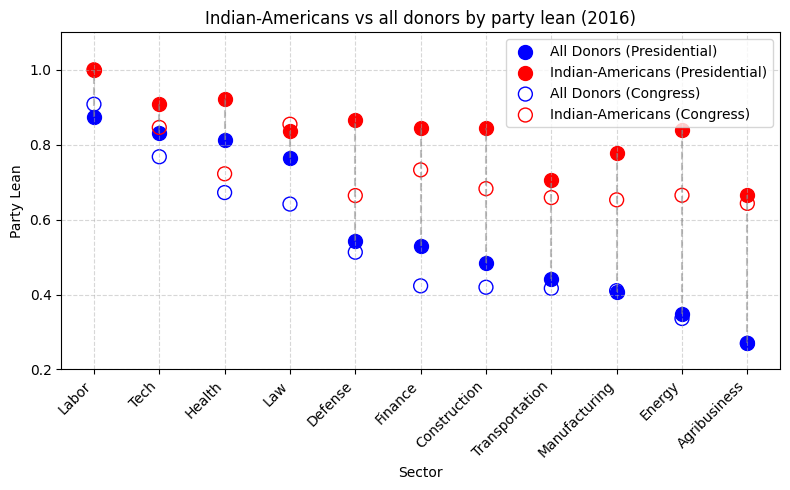

In [19]:
mean_all_pres = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] == "President")].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
mean_ind_pres = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] == "President")][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
sectors = mean_all_pres.index
mean_ind_pres = mean_ind_pres.reindex(sectors, fill_value=0)

mean_all = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] != "President")].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
mean_ind = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] != "President")][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
sectors = mean_all.index
mean_ind = mean_ind.reindex(sectors, fill_value=0)

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, mean_all_pres, mean_ind_pres):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, mean_all_pres, color='blue', label='All Donors (Presidential)', s=100)
plt.scatter(sectors, mean_ind_pres, color='red', label='Indian-Americans (Presidential)', s=100)
plt.scatter(sectors, mean_all, facecolors='none', edgecolors='blue', label='All Donors (Congress)', s=100)
plt.scatter(sectors, mean_ind, facecolors='none', edgecolors='red', label='Indian-Americans (Congress)', s=100)

plt.title(f"Indian-Americans vs all donors by party lean (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.ylim([0.2, 1.1])
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [20]:
pd.DataFrame(mean_all_pres).merge(pd.DataFrame(mean_ind_pres), left_index=True, right_index=True, suffixes=('_all_pres', '_ind_pres')).reset_index().rename(columns={'index': 'sector'})

,sector,dem_ratio_all_pres,dem_ratio_ind_pres
0,Labor,0.874163,1.000000
1,Tech,0.830732,0.908497
2,Law,0.812874,0.922713
3,Health,0.765513,0.836819
4,Defense,0.541855,0.866667
5,Finance,0.529329,0.845526
6,Manufacturing,0.485098,0.845787
7,Transportation,0.441292,0.706960
8,Energy,0.406791,0.777778
9,Construction,0.347258,0.839004


In [21]:
pd.DataFrame(mean_all).merge(pd.DataFrame(mean_ind), left_index=True, right_index=True, suffixes=('_all_cong', '_ind_cong')).reset_index().rename(columns={'index': 'sector'})

,sector,dem_ratio_all_cong,dem_ratio_ind_cong
0,Labor,0.908089,1.000000
1,Tech,0.767893,0.846146
2,Health,0.672256,0.722392
3,Law,0.641572,0.854722
4,Defense,0.513031,0.664274
5,Finance,0.423252,0.732859
6,Construction,0.419560,0.682740
7,Transportation,0.416762,0.658903
8,Manufacturing,0.410400,0.652916
9,Energy,0.336124,0.665060


In [22]:
print("Overall, presidential: ", mean_all_pres.mean())
print("Indians, presidential: ", mean_ind_pres.mean())
print("Overall, congressional: ", mean_all.mean())
print("Indians, congressional: ", mean_ind.mean())

Overall, presidential:  0.5732565439513188
Indians, presidential:  0.8378561386338738
Overall, congressional:  0.5253466194495805
Indians, congressional:  0.7384930593007746


In [23]:
state_stats = (
    donors.groupby(["state", "party", "level"])
    .agg(
        avg_amount=("total_donated", "mean"),
        med_amount=("total_donated", "median"),
        total_donations=("total_donated", "sum"),
        donor_count=("total_donated", "count"),
        avg_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].mean()),
        med_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].median()),
        total_donations_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].sum()),
        donor_count_indian=("ethnic", lambda x: (x == "ind").sum())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)
state_stats.head(10)

,state,party,level,avg_amount,med_amount,total_donations,donor_count,avg_amount_indian,med_amount_indian,total_donations_indian,donor_count_indian
0,CA,D,President,957.504464,355.0,99946231.0,104382,1179.140167,500.0,1127258.0,956
1,CA,D,Senate,955.297265,300.0,79511302.0,83232,1415.941640,500.0,897707.0,634
2,NY,D,President,1034.637623,400.0,65879516.0,63674,1242.855219,550.0,738256.0,594
3,CA,D,House,1503.950273,700.0,59520336.0,39576,2103.574599,1000.0,1705999.0,811
4,NY,D,Senate,1281.936125,500.0,54889941.0,42818,1333.037190,500.0,322595.0,242
5,TX,R,Senate,1482.139416,416.0,51507309.0,34752,2554.170455,500.0,224767.0,88
6,NY,D,House,1485.728250,750.0,41463704.0,27908,1299.393617,500.0,610715.0,470
7,CA,R,Senate,1371.887551,500.0,33489147.0,24411,2861.810127,1350.0,226083.0,79
8,FL,R,Senate,1524.824897,500.0,32594657.0,21376,2866.803030,1300.0,189209.0,66
9,CA,R,House,1417.504165,500.0,31824386.0,22451,1614.613402,775.0,313235.0,194


In [ ]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats, on="state", how="left")

In [25]:
population = pd.read_csv("./data/aapi_population.csv", sep="\t")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2020,Alabama,AL,14673,5033094,0.291530
1,2020,Alaska,AK,0,733017,0.000000
2,2020,Arizona,AZ,62246,7187135,0.866075
3,2020,Arkansas,AR,12461,3014546,0.413362
4,2020,California,CA,856180,39521958,2.166340
5,2020,Colorado,CO,33486,5787129,0.578629
6,2020,Connecticut,CT,61888,3579918,1.728755
7,2020,Delaware,DE,16076,991928,1.620682
8,2020,District of Columbia,DC,176769,670917,26.347372
9,2020,Florida,FL,181805,21592035,0.842000


In [26]:
gdf_merged = gdf_merged.merge(population, left_on="state", right_on="Code", how="left")

In [27]:
state_pivot = state_stats.pivot(index=['state', 'level'], columns='party', values='total_donations').fillna(0)
state_pivot['total'] = state_pivot['D'] + state_pivot['R']
state_pivot['dem_ratio'] = state_pivot['D'] / state_pivot['total']

state_pivot_indian = state_stats.pivot(index=['state', 'level'], columns='party', values='total_donations_indian').fillna(0)
state_pivot_indian['total'] = state_pivot_indian['D'] + state_pivot_indian['R']
state_pivot_indian['dem_ratio'] = state_pivot_indian['D'] / state_pivot_indian['total']

ratio = gdf.merge(state_pivot.reset_index(), left_on=['state'], right_on=['state'], how='right')
ratio_indian = gdf.merge(state_pivot_indian.reset_index(), left_on=['state'], right_on=['state'], how='right')

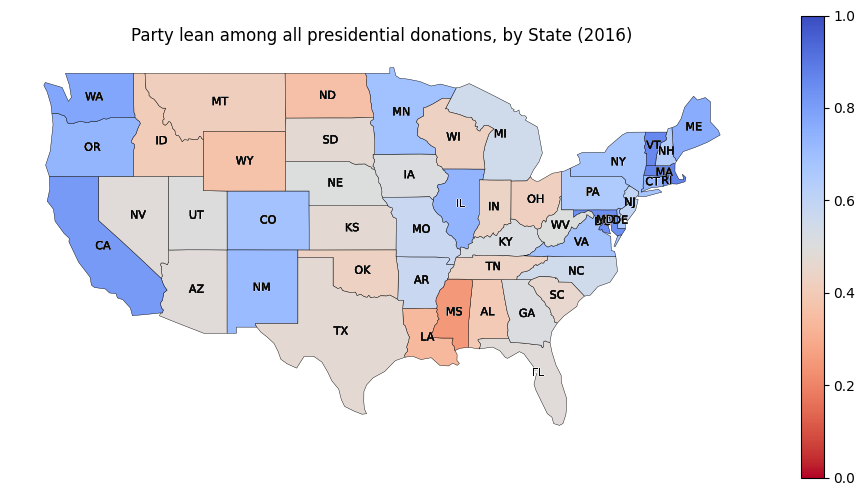

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio[ratio["level"] == "President"].plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among all presidential donations, by State (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [29]:
ratio[ratio["level"] == "President"][["state", "total"]].sort_values(by="total", ascending=False).head(10)

,state,total
35,CA,123317202.0
142,NY,97113453.0
176,TX,47011476.0
53,FL,44432165.0
93,MA,24436507.0
184,VA,23379009.0
75,IL,21865074.0
96,MD,20981028.0
132,NJ,20604505.0
156,PA,19362781.0


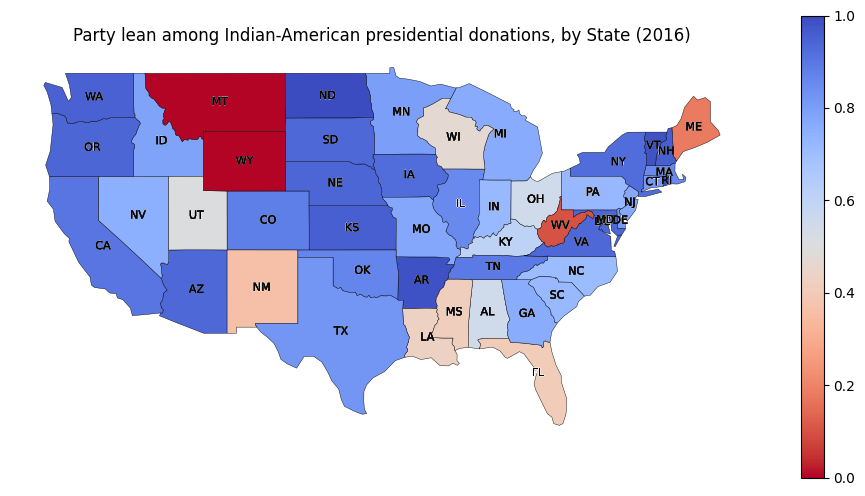

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio_indian[ratio_indian["level"] == "President"].plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among Indian-American presidential donations, by State (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [31]:
ratio_indian[ratio_indian["level"] == "President"][["state", "total"]].sort_values(by="total", ascending=False).head(10)

,state,total
35,CA,1249159.0
142,NY,798453.0
176,TX,483082.0
132,NJ,341485.0
184,VA,321854.0
53,FL,310637.0
75,IL,299933.0
96,MD,277328.0
93,MA,186991.0
44,DC,164643.0


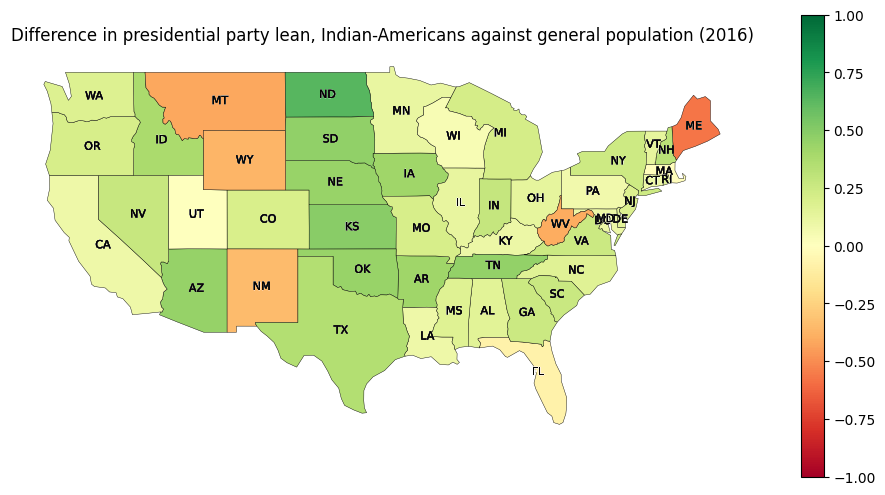

In [32]:
ratio["diff"] = ratio_indian["dem_ratio"] - ratio["dem_ratio"]

fig, ax = plt.subplots(figsize=(12, 6))
ratio[ratio["level"] == "President"].plot(
    column="diff",
    cmap="RdYlGn",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=-1,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Difference in presidential party lean, Indian-Americans against general population (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

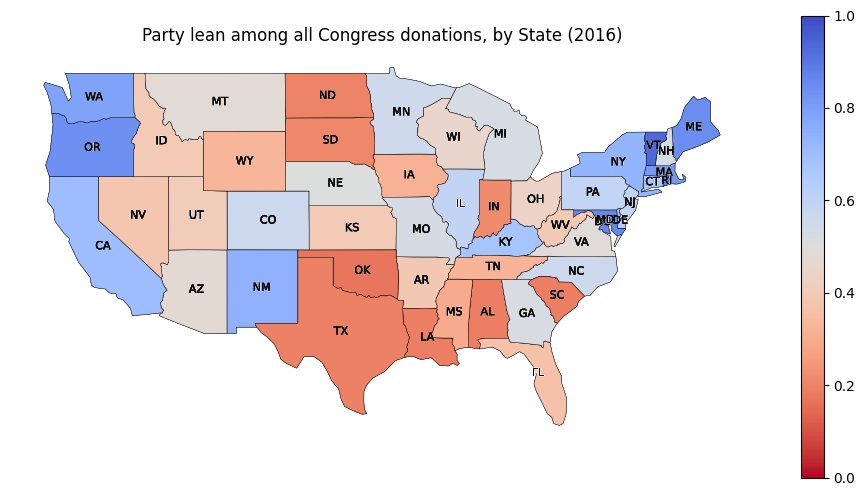

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio[ratio["level"] != "President"].plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among all Congress donations, by State (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [34]:
ratio[ratio["level"] != "President"][["state", "total", "level"]].sort_values(by="total", ascending=False).head(10)

,state,total,level
36,CA,113000449.0,Senate
34,CA,91344722.0,House
143,NY,74840996.0,Senate
177,TX,63987365.0,Senate
52,FL,61873368.0,House
141,NY,61607847.0,House
54,FL,51442586.0,Senate
175,TX,41611342.0,House
97,MD,35533186.0,Senate
76,IL,31791929.0,Senate


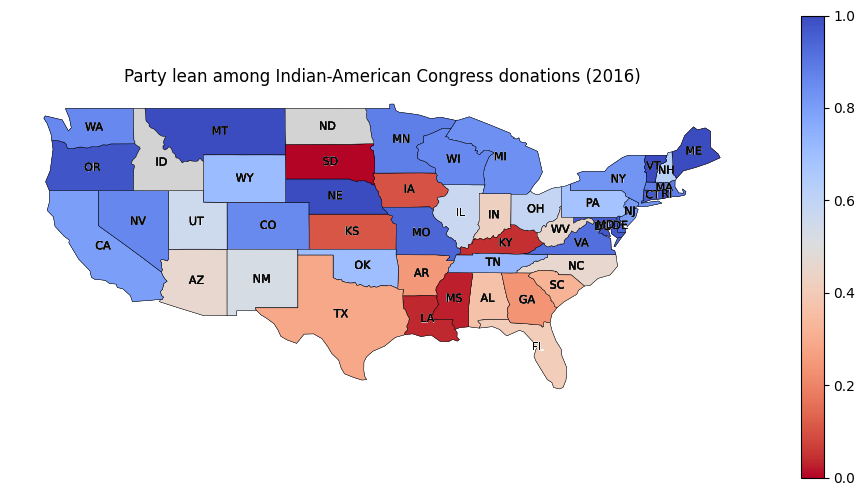

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio_indian[ratio_indian["level"] != "President"].plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among Indian-American Congress donations (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [36]:
ratio_indian[ratio_indian["level"] != "President"][["state", "total", "level"]].sort_values(by="total", ascending=False).head(10)

,state,total,level
34,CA,2019234.0,House
36,CA,1123790.0,Senate
74,IL,785317.0,House
141,NY,702873.0,House
183,VA,659213.0,House
52,FL,635900.0,House
175,TX,537881.0,House
97,MD,507229.0,Senate
143,NY,391332.0,Senate
76,IL,388185.0,Senate


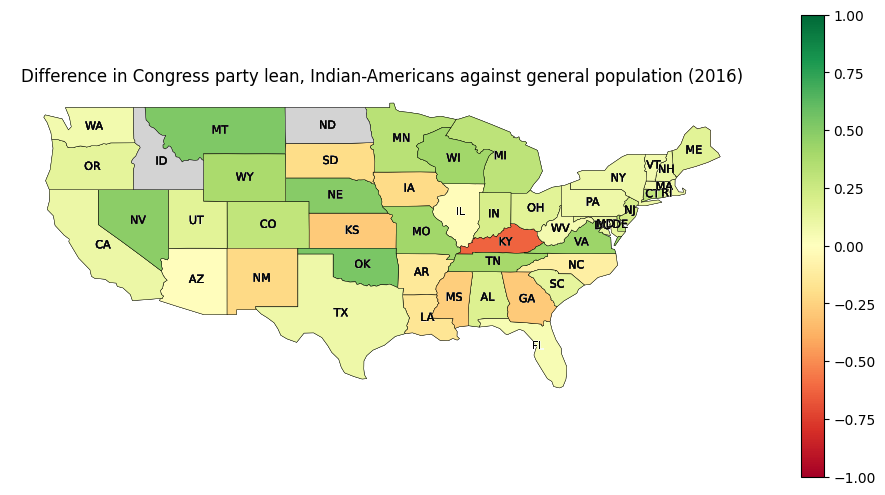

In [37]:
ratio["diff"] = ratio_indian["dem_ratio"] - ratio["dem_ratio"]

fig, ax = plt.subplots(figsize=(12, 6))
ratio[ratio["level"] != "President"].plot(
    column="diff",
    cmap="RdYlGn",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=-1,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Difference in Congress party lean, Indian-Americans against general population (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()